CELL 1: IMPORTS & CONFIGURATION 

In [1]:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_fscore_support

DATASET_ROOT = r"G:\Thesis-Fall-25-26--G-606\data"
IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

IMG_SIZE = (64, 64) 
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20
SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")


Using Device: cuda


CELL 2: DATASET CLASS 

In [2]:

class GlaucomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self): return len(self.annotations)
    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        label_str = self.annotations.iloc[index, 2]
        img_path = os.path.join(self.root_dir, img_name)
        image = cv2.imread(img_path)
        if image is None: image = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
        else: image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = 1 if label_str == 'GON+' else 0
        if self.transform: image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)



CELL 3: DEEP NN ARCHITECTURE 

In [3]:

class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.flatten = nn.Flatten()
        self.input_dim = IMG_SIZE[0] * IMG_SIZE[1] * 3
        
        # Deep Structure: Linear -> BatchNorm -> ReLU -> Dropout
        self.fc1 = nn.Linear(self.input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(512, 128)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.dropout1(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(self.relu(self.fc3(x)))
        x = self.fc4(x)
        return x


CELL 4: TRAINING ENGINE 

In [4]:

def train_model(model, train_loader, test_loader, epochs, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    
    print(f"\n--- Training {model_name} ---")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0; correct = 0; total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        history['train_acc'].append(100 * correct / total)
        history['train_loss'].append(running_loss / len(train_loader))
        
        model.eval()
        val_correct = 0; val_total = 0; val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        history['val_acc'].append(100 * val_correct / val_total)
        history['val_loss'].append(val_loss / len(test_loader))
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {history['train_acc'][-1]:.1f}% | Val Acc: {history['val_acc'][-1]:.1f}%")
    return history


CELL 5: STAGE 1 - RAW DATA (BASELINE) 

In [5]:

print("--- STAGE 1: Deep NN Baseline (Raw Data) ---")
transform_basic = transforms.Compose([transforms.ToPILImage(), transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)])
dataset = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_basic)
indices = list(range(len(dataset)))
split = int(np.floor(0.2 * len(dataset)))
np.random.seed(SEED); np.random.shuffle(indices)
train_sampler = SubsetRandomSampler(indices[split:])
test_sampler = SubsetRandomSampler(indices[:split])
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

model_nn = DeepNN()
history_raw = train_model(model_nn, train_loader, test_loader, EPOCHS, "Deep NN Baseline")


--- STAGE 1: Deep NN Baseline (Raw Data) ---

--- Training Deep NN Baseline ---
Epoch 1/20 | Train Acc: 74.4% | Val Acc: 24.2%
Epoch 2/20 | Train Acc: 87.3% | Val Acc: 24.2%
Epoch 3/20 | Train Acc: 90.8% | Val Acc: 24.2%
Epoch 4/20 | Train Acc: 93.8% | Val Acc: 24.2%
Epoch 5/20 | Train Acc: 93.5% | Val Acc: 24.8%
Epoch 6/20 | Train Acc: 95.8% | Val Acc: 34.2%
Epoch 7/20 | Train Acc: 94.3% | Val Acc: 29.5%
Epoch 8/20 | Train Acc: 95.2% | Val Acc: 46.3%
Epoch 9/20 | Train Acc: 95.7% | Val Acc: 52.3%
Epoch 10/20 | Train Acc: 95.0% | Val Acc: 59.1%
Epoch 11/20 | Train Acc: 96.3% | Val Acc: 53.7%
Epoch 12/20 | Train Acc: 95.3% | Val Acc: 26.8%
Epoch 13/20 | Train Acc: 96.8% | Val Acc: 63.1%
Epoch 14/20 | Train Acc: 97.3% | Val Acc: 92.6%
Epoch 15/20 | Train Acc: 96.5% | Val Acc: 55.7%
Epoch 16/20 | Train Acc: 96.7% | Val Acc: 56.4%
Epoch 17/20 | Train Acc: 97.0% | Val Acc: 87.9%
Epoch 18/20 | Train Acc: 95.5% | Val Acc: 46.3%
Epoch 19/20 | Train Acc: 96.0% | Val Acc: 83.2%
Epoch 20/20 | Tra

CELL 6: STAGE 2 - AUGMENTED DATA 

In [6]:


print("\n--- STAGE 2: Deep NN Augmented (Improved) ---")
transform_aug = transforms.Compose([
    transforms.ToPILImage(), transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(15), transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
])
dataset_aug = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)
train_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=test_sampler)

model_nn_aug = DeepNN()
history_aug = train_model(model_nn_aug, train_loader_aug, test_loader_aug, EPOCHS, "Augmented Deep NN")



--- STAGE 2: Deep NN Augmented (Improved) ---

--- Training Augmented Deep NN ---
Epoch 1/20 | Train Acc: 72.1% | Val Acc: 24.2%
Epoch 2/20 | Train Acc: 79.9% | Val Acc: 24.2%
Epoch 3/20 | Train Acc: 89.5% | Val Acc: 24.2%
Epoch 4/20 | Train Acc: 88.8% | Val Acc: 24.2%
Epoch 5/20 | Train Acc: 89.6% | Val Acc: 28.9%
Epoch 6/20 | Train Acc: 91.8% | Val Acc: 54.4%
Epoch 7/20 | Train Acc: 92.8% | Val Acc: 38.3%
Epoch 8/20 | Train Acc: 91.8% | Val Acc: 25.5%
Epoch 9/20 | Train Acc: 91.8% | Val Acc: 34.2%
Epoch 10/20 | Train Acc: 92.1% | Val Acc: 81.2%
Epoch 11/20 | Train Acc: 93.3% | Val Acc: 49.0%
Epoch 12/20 | Train Acc: 90.6% | Val Acc: 47.0%
Epoch 13/20 | Train Acc: 94.5% | Val Acc: 65.1%
Epoch 14/20 | Train Acc: 94.6% | Val Acc: 37.6%
Epoch 15/20 | Train Acc: 93.5% | Val Acc: 73.8%
Epoch 16/20 | Train Acc: 93.8% | Val Acc: 93.3%
Epoch 17/20 | Train Acc: 94.5% | Val Acc: 89.3%
Epoch 18/20 | Train Acc: 95.0% | Val Acc: 83.9%
Epoch 19/20 | Train Acc: 95.2% | Val Acc: 87.2%
Epoch 20/20 | 

CELL 7: STAGE 3 - CROSS VALIDATION 

In [7]:

print("\n--- STAGE 3: 5-Fold Cross Validation ---")
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = []
dataset_cv = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset_cv)):
    print(f"Fold {fold+1}/5...")
    train_sub = SubsetRandomSampler(train_ids)
    val_sub = SubsetRandomSampler(val_ids)
    trainloader_cv = DataLoader(dataset_cv, batch_size=BATCH_SIZE, sampler=train_sub)
    valloader_cv = DataLoader(dataset_cv, batch_size=BATCH_SIZE, sampler=val_sub)
    
    model_cv = DeepNN()
    model_cv.to(device)
    optimizer = optim.Adam(model_cv.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(10): 
        model_cv.train()
        for img, lab in trainloader_cv:
            img, lab = img.to(device), lab.to(device)
            optimizer.zero_grad()
            outputs = model_cv(img)
            loss = criterion(outputs, lab)
            loss.backward()
            optimizer.step()
    
    model_cv.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for img, lab in valloader_cv:
            img, lab = img.to(device), lab.to(device)
            outputs = model_cv(img)
            _, predicted = torch.max(outputs.data, 1)
            total += lab.size(0); correct += (predicted == lab).sum().item()
    acc = 100 * correct / total
    cv_scores.append(acc)
    print(f"   Accuracy: {acc:.2f}%")
print(f"Avg CV Accuracy: {np.mean(cv_scores):.2f}%")



--- STAGE 3: 5-Fold Cross Validation ---
Fold 1/5...
   Accuracy: 85.33%
Fold 2/5...
   Accuracy: 35.33%
Fold 3/5...
   Accuracy: 59.73%
Fold 4/5...
   Accuracy: 89.26%
Fold 5/5...
   Accuracy: 32.21%
Avg CV Accuracy: 60.37%


CELL 8: VISUALIZATION 

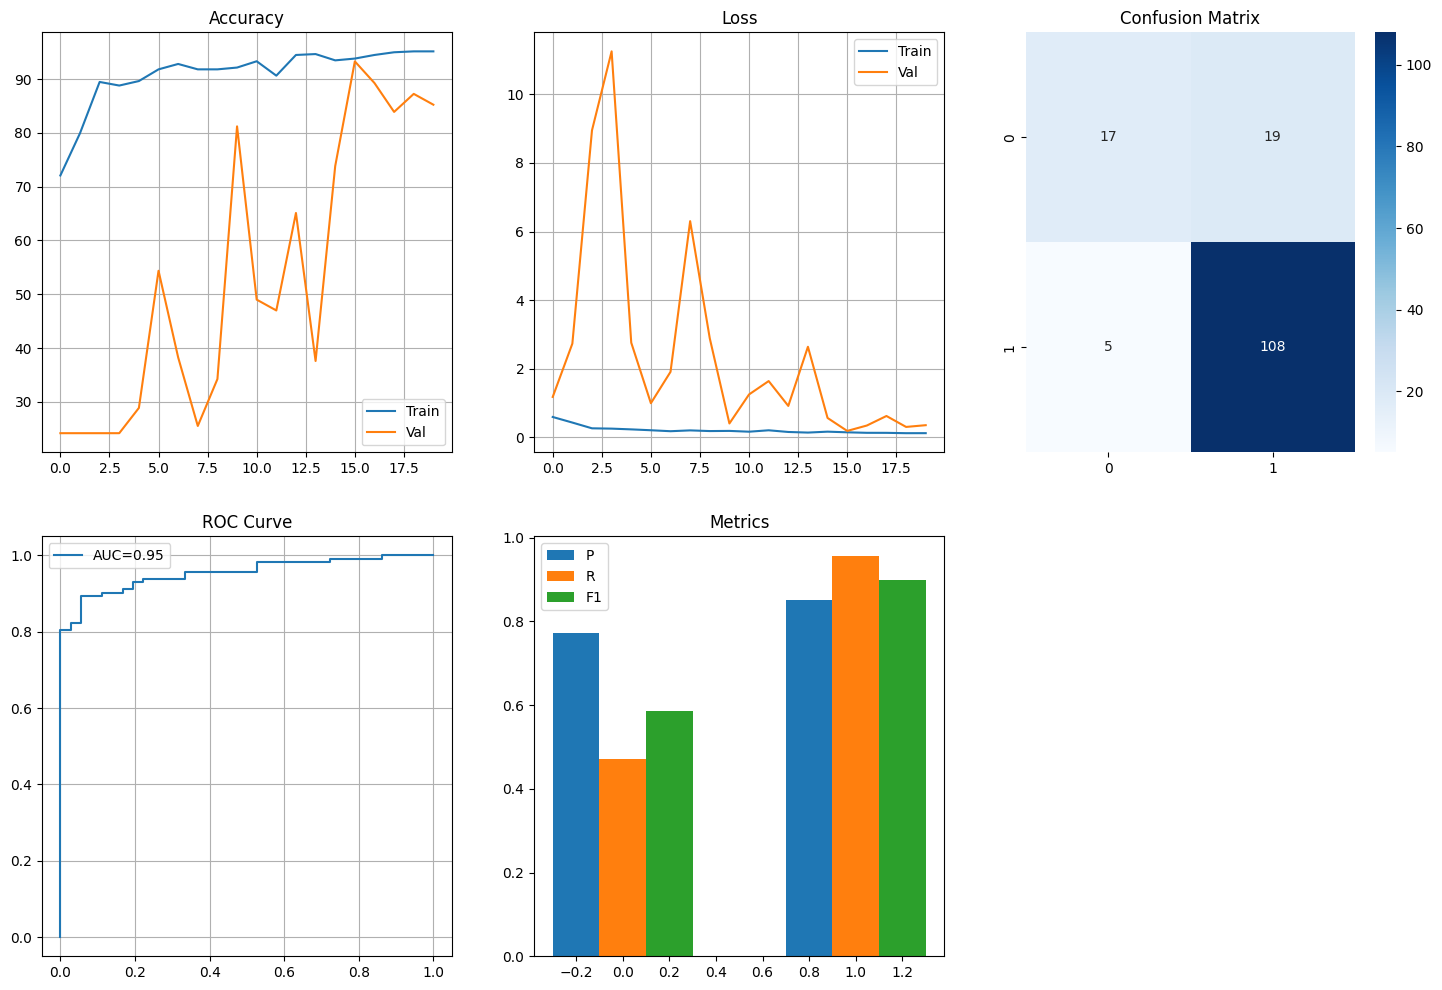


--- Predictions: GON+ vs Healthy ---


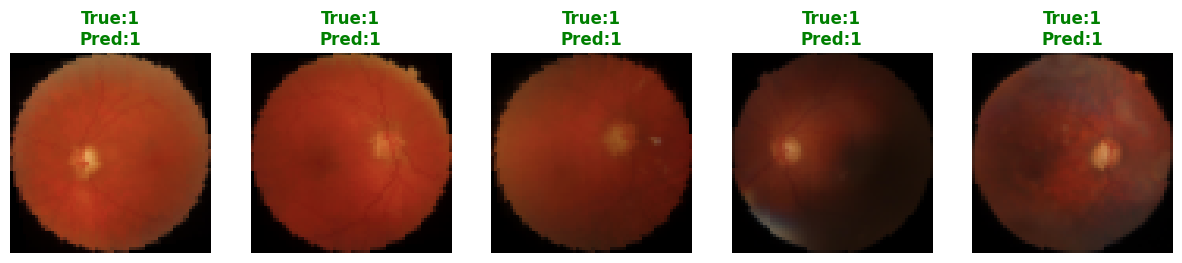

In [8]:


def show_results(history, model, loader):
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 3, 1); plt.plot(history['train_acc'], label='Train'); plt.plot(history['val_acc'], label='Val'); plt.title('Accuracy'); plt.legend(); plt.grid()
    plt.subplot(2, 3, 2); plt.plot(history['train_loss'], label='Train'); plt.plot(history['val_loss'], label='Val'); plt.title('Loss'); plt.legend(); plt.grid()
    
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for img, lab in loader:
            img, lab = img.to(device), lab.to(device)
            out = model(img)
            probs = torch.softmax(out, dim=1)
            _, pred = torch.max(out, 1)
            y_true.extend(lab.cpu().numpy()); y_pred.extend(pred.cpu().numpy()); y_probs.extend(probs[:, 1].cpu().numpy())

    plt.subplot(2, 3, 3); sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues'); plt.title('Confusion Matrix')
    plt.subplot(2, 3, 4); fpr, tpr, _ = roc_curve(y_true, y_probs); plt.plot(fpr, tpr, label=f'AUC={auc(fpr, tpr):.2f}'); plt.title('ROC Curve'); plt.legend(); plt.grid()
    plt.subplot(2, 3, 5); p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average=None); x=np.arange(2); plt.bar(x-0.2, p, 0.2, label='P'); plt.bar(x, r, 0.2, label='R'); plt.bar(x+0.2, f, 0.2, label='F1'); plt.legend(); plt.title('Metrics')
    plt.show()

    print("\n--- Predictions: GON+ vs Healthy ---")
    plt.figure(figsize=(15, 5))
    imgs, labs = next(iter(loader))
    imgs = imgs.to(device)
    with torch.no_grad(): preds = model(imgs).argmax(dim=1)
    for i in range(min(5, len(imgs))):
        plt.subplot(1, 5, i+1); plt.imshow(np.clip(imgs[i].cpu().permute(1,2,0).numpy()*0.5+0.5, 0, 1))
        col = 'green' if preds[i]==labs[i] else 'red'
        plt.title(f"True:{labs[i].item()}\nPred:{preds[i].item()}", color=col, fontweight='bold'); plt.axis('off')
    plt.show()

show_results(history_aug, model_nn_aug, test_loader_aug)


CELL 9: SAVE MODEL 

In [9]:

save_path = os.path.join(DATASET_ROOT, 'nn_best_model.pth')
torch.save(model_nn_aug.state_dict(), save_path)
print(f"Deep NN Model Saved: {save_path}")

Deep NN Model Saved: G:\Thesis-Fall-25-26--G-606\data\nn_best_model.pth
